# Passive Network Measurement

Network operators look at different types of network traffic data to understand properties of their networks. Some network data can be collected directly from network devices (e.g., routers, switches) while they are forwarding live traffic.  Collecting this data does not affect network behavior and is therefore called "passive" (as opposed to "active" measurements).

In this assignment, you will analyze two types of passive network measurement data---traffic volumes and BGP routes.

This notebook has several parts. Each part contains sections marked with TODO that you need to complete. 

**Put your name and netID in the cell below:**

**Name:姚凯文**

**NetId:10224507041**

## Background

### Traffic Measurement with IPFIX

Routers in most networks collect traffic measurements using the [IPFIX protocol](https://en.wikipedia.org/wiki/IP_Flow_Information_Export). [NetFlow](https://en.wikipedia.org/wiki/NetFlow), a proprietary form of IPFIX defined by Cisco, is well-known in the networks community because Cisco supplies routers for many large networks.

In this part of the assignment, you'll analyze a trace of NetFlow records captured from a router that connects the Princeton campus network to the Internet. The assignment will ask you to perform similar kinds of analysis that a network operator would perform -- asking questions about the most popular endpoints for traffic on the Princeton campus, the most popular web applications, and so forth. (As you can imagine, when we start to think about security, the ability to analyze these baselines will come in handy!)

The flow records are in the file 'netflow.csv' in the folder.  To simplify the analysis, we have ensured that the IP addresses of the Princeton campus network start with 128.112 and have their 16 lower bits anonymized to protect the privacy of users on the campus network (i.e., all of us!). To further simplify your task, we have parsed these records into CSV (comma-separated variable) format, with the names of the fields listed in the first row of the file. (In a real network, routers export IPFIX records as binary files.)

### Measurement of Interdomain Routing with BGP Routing Tables

To help network operators understand the state of Internet routing, many routers have the ability to "dump" BGP routing tables periodically into a static file. These routing tables contain information about each IP prefix, all BGP routes that the router learns for each prefix, and the "best" BGP route that the router ultimately selects. Analyzing the BGP routing tables can provide information about where traffic to different IP prefixes is destined.

In this assignment, we have provided you a routing table dump from a project called [RouteViews](http://www.routeviews.org/). You can visit that site to learn more about the routing tables that they collect. `telnet route-views2.routeviews.org` will also give you a command-line prompt at a real BGP router at the routeviews project if you want to play around with a live routing table view.  http://routeviews.org/bgpdata/ has periodic binary routing table dumps and update logs from participating routers. Again, for this assignment, we have parsed the binary routing table dumps into a format that is easier to analyze directly. The data is located in the `bgp_rib.csv` file.

### Functional data analysis with map() and reduce()

Several of the data analysis steps in this assignment use a "MapReduce" programming model. MapReduce originated in functional programming languages and involves using two functions (called `map()` and `reduce()`...surprise!) to apply functions to iterable data (like linked-lists, arrays, etc.). 

##### map()

A general `map()` function has two arguments: another function (which itself takes one argument) and an iterable object. `map()` then applies (maps) the argument function to every item in the iterable object. See the documentation of Python's built-in `map()`function for more details: https://docs.python.org/2/library/functions.html#map. The following toy example uses `map()` to add 3 to every element of a list

In [1]:
some_numbers = [1,2,3]
three_more = map(lambda x: x+3, some_numbers)
print three_more

[4, 5, 6]


`map()` is often used with anonymous function (the `lambda` in the above example), but can be used just as easily with normal functions:

In [2]:
def add3(i):
    return i+3
 
some_numbers = [1,2,3]
three_more = map(add3, some_numbers)
print three_more

[4, 5, 6]


Note that real implementations of `map()` allow the mapped function to take more than one argument or include more information in a closure, but this won't be necessary for this assignment.

##### reduce()

A general `reduce()` function takes another function (which itself takes *two* values), an iterable object, and an optional initializer value.  The argument function is applied to the first two elements in the iterable object (or the first element and the initializer value) to get a return value. The function is then applied to this return value and the next item in the iterable object. This continues through the iterable object until only a single return value remains. This allows `reduce()` to compute summaries over all data in the iterable object. See the documentation of Python's built-in `reduce()` function for more details: https://docs.python.org/2/library/functions.html#reduce. The following example uses `reduce()` to count the number of 4s in a list of integers:

In [3]:
def count_4s(count, i):
    # The order of the arguments matters. 
    #     The first argument is the accumulated value
    #     The secod argument is next value from the iterable
    if i == 4:
        return count + 1
    else:
        return count

some_numbers = [1,4,0,1,4]
num_fours = reduce(count_4s, some_numbers, 0) # 0 is the initializer value 
print num_fours

2


Again, real implementations of `reduce()` allow the reduction function to take more than two arguments or include more information in a closure, but this won't be necessary for this assignment.

[MapReduce](https://en.wikipedia.org/wiki/MapReduce) is popular because it allows analysis tasks on large data sets to be easily parallelized .  Although there are many open-source and proprietary MapReduce-style data processing libraries (typically with different ways of expressing iterable datasets and distributing tasks over many computers), they all involve `map()` and `reduce()` functions like you will use in this assignment.  If you are interested in learning more about functional programming for data analysis, you should take COS 326.

## Part A: IPFIX Data

### Parse IPFIX Data
The `netflow.csv` file contains pre-processed netflow data from a Princeton campus network border router. The data is "unsampled," i.e. it compiles flow statistics for every packet that traverses any interface on the border router.  We used the `nfdump` tool to process the raw NetFlow data that the router collected. Each row of the `netflow.csv` file, except for the header on top, logs the following information for a flow:

```
Date first seen, Time first seen (m:s), Date last seen, Time last seen (m:s), Duration (s), Protocol, 
Src IP addr, Src port, Dst IP addr, Dst port, Packets, Bytes, Flags, Input interface, Output interface		

```

To analyze this data, we first need to read it into a python data structure.  The following code uses the built-in `csv` library to read `netflow.csv` into a list of dictionaries.  The `csv` library documentation is here if you are interested: https://docs.python.org/2/library/csv.html


In [4]:
import csv

with open('netflow.csv', 'r') as netflow_file:
    netflow_reader = csv.DictReader(netflow_file)
    netflow_data = list(netflow_reader)
    
print "Number of flow records: {}".format(len(netflow_data))
print
print "Sample flow record: {}".format(netflow_data[0])

Number of flow records: 105360

Sample flow record: {'Dst IP addr': '128.112.213.189', 'Protocol': 'ICMP', 'Bytes': '94', 'Src port': '0', 'Src IP addr': '172.16.241.1', 'Input interface': '120', 'Packets': '1', 'Date first seen': '10/29/15', 'Output interface': '0', 'Duration (s)': '0', 'Time first seen (m:s)': '04:48.9', 'Flags': '.A....', 'Time last seen (m:s)': '04:48.9', 'Dst port': '11', 'Date last seen': '10/29/15'}


### Analyze IPFIX Data

The following sections each focus on answering a specific question using the netflow data you have prepared. These questions are both of interest to real network operators and might reveal some surprising facts about how we (as a Princton community) use the Internet.  

#### What are the most popular IP addresses accessed by users of the Princeton network?

In order to answer this question, we have to decide how to measure IP address popularity. Total traffic volume across all flows seems like a reasonable option, but so does total number of flows to an IP address regardless of volume.  Network operaters actually use both metrics (among others), which we will do here as well.  

*Step 1: Determine popular IP addresses by number of flows*

Complete the following code to produce a python dictionary `ips_by_flows` with counts of the total number of flows to each external (not 128.112.\*.\*) IP address in `netflow_data`.  The keys of the dict should be IP addresses and the values should be integer flow counts.

First complete the `count_by_flows()` function, which should take an existing dict of the form described above and update it appropriately from `current_flow`.  If you are confused about datatypes, use print statements to inspect variables. 

You may want to create an additional helper function to test if an IP address starts with 128.112. Helpful string methods are documented here: https://docs.python.org/2/library/stdtypes.html#string-methods.

You will then need to use the `reduce()` function to build a dictionary result.  As a hint, the initializer argument to `reduce()` should be `defaultdict(lambda: 0)`. The [defaultdict()](https://docs.python.org/2/library/collections.html#collections.defaultdict)  function creates a dictionary with default values that are the output of the argument function (in this case, just 0). This allows you to increment the value of a particular key without first checking to see if the key is already in the dictionary (if you used `{}` to create the dict instead of `defaultdict()`, this would raise a KeyError).

The provided code will print and plot the most popular IPs.  The `check_ips_by_flows()` function will compare the md5 hash of the top 15 most popular IPs your answer against the md5 hash of the correct answer. This will print a message letting you know whether you are correct or need to keep debugging. 

Most popular IP addresses by number of flows: [('116.211.0.90', 17015), ('169.54.233.126', 9424), ('163.53.247.3', 2981), ('169.45.161.189', 2494), ('222.186.190.71', 2413)]

Hashes match. Your ips_by_flows is correct.


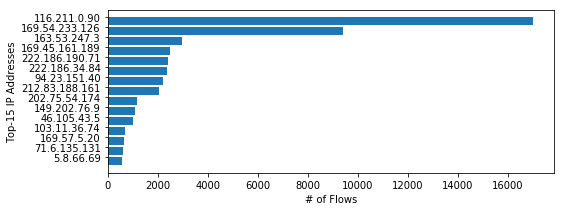

In [5]:
%matplotlib inline
from collections import defaultdict
from plotting import plot_flows
from testing import check_ips_by_flows

# TODO: complete count_by_flows function
def count_by_flows(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    # 提取目标IP地址
    dst_ip = current_flow['Dst IP addr']
    src_ip = current_flow['Src IP addr']
    
    # 检查IP地址是否以'128.112.'开头
    if not dst_ip.startswith('128.112.'):
        # 更新字典中的计数
        counts[dst_ip] += 1
    if not src_ip.startswith('128.112.'):
        # 更新字典中的计数
        counts[src_ip] += 1
    return counts
    pass
      

# TODO: use reduce() function to apply count_by_flows to netflow_data and assign the result to ips_by_flows

# 初始化一个defaultdict，所有IP地址的初始计数为0
ips_by_flows=reduce(count_by_flows, netflow_data,defaultdict(lambda:0))

# print the top 5 IP addresses by number of flows 
sorted_ips_by_flows = sorted(ips_by_flows.items(), reverse=True, key=lambda x: x[1])
print "Most popular IP addresses by number of flows: {}\n".format(sorted_ips_by_flows[0:5])

# check the results
check_ips_by_flows(sorted_ips_by_flows[0:15])

# plot the results
plot_flows(sorted_ips_by_flows)

*Step 2: Determine popular IP addresses by total volume*

Complete the following code to produce a dict `ips_by_volume` with counts of the total number of bytes to each external (non-Princeton) IP address.  The keys of the dict should be IP addresses and the values should be integer byte counts. Remember that the values in `netflow_data` are strings. You will need to convert them to ints or floats to do arithmetic.

Most popular IP addresses by volume: [('212.83.188.161', 928311), ('169.54.233.126', 867928), ('116.211.0.90', 680600), ('169.45.161.189', 229448), ('42.120.221.22', 191958)]

Hashes match. Your ips_by_volume is correct.


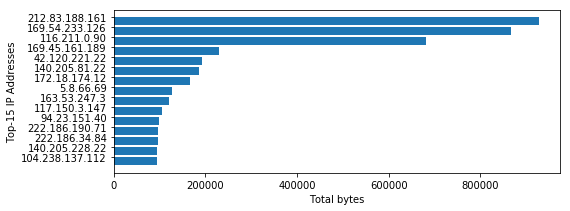

In [6]:
%matplotlib inline
from plotting import plot_volumes
from testing import check_ips_by_volume

# TODO: complete count_by_volume function
def count_by_volume(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    #提取目标IP地址
    myBytes=int(current_flow['Bytes'])
    dst_ip=current_flow['Dst IP addr']
    src_ip=current_flow['Src IP addr']
    
    # 检查IP地址是否以'128.112.'开头
    if not dst_ip.startswith('128.112.'):
        # 更新字典中的计数
        counts[dst_ip] += myBytes
    if not src_ip.startswith('128.112.'):
        # 更新字典中的计数
        counts[src_ip] += myBytes
    return counts
    pass

        
# TODO: use reduce() function to apply count_by_volume to netflow_data and assign the result to ips_by_volume
ips_by_volume=reduce(count_by_volume, netflow_data,defaultdict(lambda:0))


# print the top 5 IP addresses by volume
sorted_ips_by_volume = sorted(ips_by_volume.items(), reverse=True, key=lambda x: x[1])
print "Most popular IP addresses by volume: {}\n".format(sorted_ips_by_volume[0:5])

# check the results
check_ips_by_volume(sorted_ips_by_volume[0:15])

# plot the results
plot_volumes(sorted_ips_by_volume)

#### What are the most popular applications (by protocol) for Princeton network users?

What application protocols do you think are the most common on the Princeton network?  Web traffic (HTTP & SSL)? Secure remote connection (SSH)? Email (SMTP, IMAP, POP3)?  In practice, a network operator may want to identify popular applications  to make provisioning plans or change network configurations to treat traffic from different applications differently (e.g., to route traffic on different links). This could prevent high-volume applications, (e.g. video streaming) from interrupting the performance of critical low-volume applications.  

You can answer these questions by finding the most popular ports of traffic flows in the netflow data. Many application protocols use well-known fixed ports for their traffic.  For example, HTTP traffic happens on port 80, SSL traffic on port 443, SSH traffic on port 22, SMTP on port 25. 

Again we will use both number of flows and total traffic volume as metrics for port "popularity".

Complete the following code to create `ports_by_flows` and `ports_by_volume` dicts from the netflow data.  Use the same strategy as you did above to create `ips_by_flows` and `ips_by_volume`. 

Include all destination ports and source ports **lower than 1024** (ports lower than 1024 are "well-known" and easily mapped to applications). 

Most popular ports by number of flows: [('23', 19546), ('53', 6480), ('80', 6352), ('443', 5788), ('0', 4712)]
Most popular ports by volume: [('23', 2324852), ('53', 1437375), ('161', 752840), ('0', 509011), ('80', 309148)]

Hashes match. Your ports_by_flows is correct.
Hashes match. Your ports_by_volume is correct.


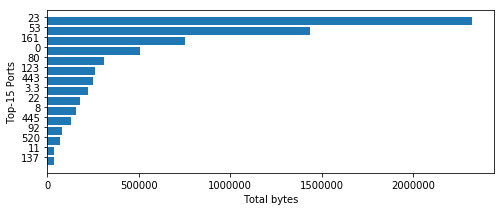

In [7]:
%matplotlib inline
from plotting import plot_ports
from testing import check_ports_by_flows, check_ports_by_volume

# TODO: create ports_by_flows and ports_by_volume dicts from netflow_data
def port_count_by_flows(counts, current_flow):
    dst_port=current_flow['Dst port']
    src_port=current_flow['Src port']
    if float(dst_port) < 1024:
        counts[dst_port] += 1
    if float(src_port) < 1024:
        counts[src_port] += 1
    return counts
    pass
      
ports_by_flows=reduce(port_count_by_flows, netflow_data,defaultdict(lambda:0))

def port_count_by_volume(counts, current_flow):
    dst_port=current_flow['Dst port']
    src_port=current_flow['Src port']
    bytes=int(current_flow['Bytes'])
    if float(dst_port) < 1024:
        counts[dst_port] += bytes
    if float(src_port) < 1024:
        counts[src_port] += bytes

    return counts
    pass

ports_by_volume=reduce(port_count_by_volume, netflow_data,defaultdict(lambda:0))

# Print the most popular ports and check the results
sorted_ports_by_flows = sorted(ports_by_flows.items(), reverse=True, key=lambda x: x[1])
sorted_ports_by_volume = sorted(ports_by_volume.items(), reverse=True, key=lambda x: x[1])
print "Most popular ports by number of flows: {}".format(sorted_ports_by_flows[0:5])
print "Most popular ports by volume: {}\n".format(sorted_ports_by_volume[0:5])
check_ports_by_flows(sorted_ports_by_flows[0:15])
check_ports_by_volume(sorted_ports_by_volume[0:15])

# plot the results 
plot_ports(sorted_ports_by_flows, sorted_ports_by_volume)

### Questions

Answer the following questions about the results of the above analysis. 

#### Q1. 
What are the 5 most popular external (non-Princeton) IP addresses by number of flows and by traffic volume?

#### A1.
*TODO: Your answer here.*

Most popular IP addresses by number of flows: [('116.211.0.90', 17015), ('169.54.233.126', 9424), ('163.53.247.3', 2981), ('169.45.161.189', 2494), ('222.186.190.71', 2413)]


Most popular IP addresses by volume: [('212.83.188.161', 928311), ('169.54.233.126', 867928), ('116.211.0.90', 680600), ('169.45.161.189', 229448), ('42.120.221.22', 191958)]

#### Q2. 
Use the "whois" command from your Vagrant terminal to learn what you can about these IP addresses (e.g. `whois 169.54.233.126`).  Choose 2 addresses from your answer to Q1 and write up what you learned, as well as why you think they were among the most popular. 

#### A2. 
*TODO: Your answer here.*

1.

##### 116.211.0.90:

% [whois.apnic.net]
% Whois data copyright terms    http://www.apnic.net/db/dbcopyright.html

% Information related to '116.208.0.0 - 116.211.255.255'

% Abuse contact for '116.208.0.0 - 116.211.255.255' is 'email@chinatelecom.cn'

inetnum:        116.208.0.0 - 116.211.255.255
netname:        CHINANET-HB
descr:          CHINANET Hubei province network
descr:          Data Communication Division
descr:          China Telecom
country:        CN
admin-c:        CH93-AP
tech-c:         CHA1-AP
abuse-c:        AC1573-AP
status:         ALLOCATED PORTABLE
remarks:        --------------------------------------------------------
remarks:        To report network abuse, please contact mnt-irt
remarks:        For troubleshooting, please contact tech-c and admin-c
remarks:        Report invalid contact via www.apnic.net/invalidcontact
remarks:        --------------------------------------------------------
mnt-by:         APNIC-HM
mnt-lower:      MAINT-CN-CHINANET-HB
mnt-irt:        IRT-CHINANET-CN
last-modified:  2021-06-15T08:05:18Z
source:         APNIC

irt:            IRT-CHINANET-CN
address:        No.31 ,jingrong street,beijing
address:        100032
e-mail:         email@chinatelecom.cn
abuse-mailbox:  email@chinatelecom.cn
admin-c:        CH93-AP
tech-c:         CH93-AP
auth:           # Filtered
remarks:        email@chinatelecom.cn was validated on 2023-10-08
mnt-by:         MAINT-CHINANET
last-modified:  2023-10-08T08:55:58Z
source:         APNIC

role:           ABUSE CHINANETCN
address:        No.31 ,jingrong street,beijing
address:        100032
country:        ZZ
phone:          +000000000
e-mail:         email@chinatelecom.cn
admin-c:        CH93-AP
tech-c:         CH93-AP
nic-hdl:        AC1573-AP
remarks:        Generated from irt object IRT-CHINANET-CN
remarks:        email@chinatelecom.cn was validated on 2023-10-08
abuse-mailbox:  email@chinatelecom.cn
mnt-by:         APNIC-ABUSE
last-modified:  2023-10-08T08:56:49Z
source:         APNIC

role:           CHINANET HB ADMIN
address:        8th floor of JinGuang Building
address:        #232 of Macao Road
address:        HanKou Wuhan Hubei Province
address:        P.R.China
country:        CN
phone:          +86 27 82862199
fax-no:         +86 27 82861499
e-mail:         email@189.cn
remarks:        send spam reports to email@189.cn
remarks:        and abuse reports to email@189.cn
remarks:        Please include detailed information and
remarks:        times in GMT+8
admin-c:        YZ83-AP
admin-c:        ZC77-AP
tech-c:         YZ83-AP
tech-c:         ZC77-AP
nic-hdl:        CHA1-AP
notify:         email@189.cn
mnt-by:         MAINT-CN-CHINANET-HB
last-modified:  2013-08-06T11:09:18Z
source:         APNIC

person:         Chinanet Hostmaster
nic-hdl:        CH93-AP
e-mail:         email@chinatelecom.cn
address:        No.31 ,jingrong street,beijing
address:        100032
phone:          +86-10-58501724
fax-no:         +86-10-58501724
country:        CN
mnt-by:         MAINT-CHINANET
last-modified:  2022-02-28T06:53:44Z
source:         APNIC

% Information related to '116.211.0.0/18AS4809'

route:          116.211.0.0/18
descr:          CHINANET HUBEI PROVINCE NETWORK
origin:         AS4809
mnt-by:         MAINT-CN-CHINANET-HB
mnt-by:         MAINT-CHINANET
last-modified:  2008-09-04T07:55:08Z
source:         APNIC

% This query was served by the APNIC Whois Service version 1.88.25 (WHOIS-US3)

IP地址范围包括了从116.208.0.0到116.211.255.255的所有IP地址。"country: CN"表明这个IP地址范围位于中国。网络名称为"CHINANET-HB"，描述为"CHINANET Hubei province network"。这表示这个IP地址范围属于中国电信（China Telecom）旗下的湖北省网络，该网络用于在湖北省提供互联网连接。


2.

##### 212.83.188.161:

% This is the RIPE Database query service.
% The objects are in RPSL format.
%
% The RIPE Database is subject to Terms and Conditions.
% See https://apps.db.ripe.net/docs/HTML-Terms-And-Conditions

% Note: this output has been filtered.
%       To receive output for a database update, use the "-B" flag.

% Information related to '212.83.160.0 - 212.83.191.255'

% Abuse contact for '212.83.160.0 - 212.83.191.255' is 'email@online.net'

inetnum:        212.83.160.0 - 212.83.191.255
netname:        SCALEWAY-DEDIBOX-IPFO
descr:          Scaleway Dedibox IPFO
remarks:        Abuse reports : https://abuse.online.net/
country:        FR
org:            ORG-ONLI1-RIPE
admin-c:        TTFR1-RIPE
tech-c:         TCP8-RIPE
status:         ASSIGNED PA
mnt-by:         MNT-TISCALIFR
mnt-by:         MNT-TISCALIFR-B2B
mnt-by:         ONLINE-NET-MNT
created:        2002-09-24T15:24:29Z
last-modified:  2022-05-04T17:24:57Z
source:         RIPE

organisation:   ORG-ONLI1-RIPE
mnt-ref:        MNT-TISCALIFR-B2B
org-name:       Scaleway
org-type:       OTHER
address:        8 rue de la ville l'eveque 75008 PARIS
abuse-c:        AR32851-RIPE
mnt-ref:        ONLINE-NET-MNT
mnt-by:         ONLINE-NET-MNT
created:        2015-07-10T15:20:41Z
last-modified:  2022-05-03T15:39:01Z
source:         RIPE # Filtered

role:           Technical Contact for ProXad
address:        Free SAS / ProXad
address:        8, rue de la Ville L'Eveque
address:        75008 Paris
phone:          +33 1 73 50 20 00
fax-no:         +33 1 73 92 25 69
remarks:        trouble:      Information: http://www.proxad.net/
remarks:        trouble:      Spam/Abuse requests: mailto:email@proxad.net
admin-c:        APfP1-RIPE
tech-c:         TPfP1-RIPE
nic-hdl:        TCP8-RIPE
mnt-by:         PROXAD-MNT
created:        2002-06-26T12:29:10Z
last-modified:  2011-06-14T09:03:07Z
source:         RIPE # Filtered
abuse-mailbox:  email@proxad.net

role:           SCALEWAY
remarks:        known as Online S.A.S. / Iliad-Entreprises
address:        8 rue de la ville l'évèque
address:        75008 Paris
address:        France
abuse-mailbox:  email@online.net
admin-c:        IENT-RIPE
tech-c:         IENT-RIPE
nic-hdl:        TTFR1-RIPE
mnt-by:         MNT-TISCALIFR
mnt-by:         ONLINE-NET-MNT
created:        2002-09-24T14:16:42Z
last-modified:  2022-05-03T15:52:58Z
source:         RIPE # Filtered

% Information related to '212.83.160.0/19AS12876'

route:          212.83.160.0/19
descr:          Scaleway
descr:          Paris, France
origin:         AS12876
mnt-by:         MNT-TISCALIFR
mnt-lower:      ONLINE-NET-MNT
created:        2013-08-02T09:07:45Z
last-modified:  2022-05-03T10:05:57Z
source:         RIPE

% This query was served by the RIPE Database Query Service version 1.108 (SHETLAND)

IP地址范围包括了从212.83.160.0到212.83.191.255的所有IP地址。网络名称为"SCALEWAY-DEDIBOX-IPFO"，描述为"Scaleway Dedibox IPFO"。这表示这个IP地址范围与Scaleway Dedibox IPFO相关，通常用于数据中心、虚拟主机或云服务。"country: FR"表明这个IP地址范围位于法国。管理组织名称为"Scaleway"，并具有一些相关联系信息。这是负责管理和维护该IP地址范围的组织。

这两个IP地址范围之所以成为最受欢迎的IP地址，可能是因为它们与大量的网络通信流量相关，这可能包括湖北省内部的通信或法国托管的在线服务。这些流量通常代表了网络中的重要节点或资源，因此它们成为最受欢迎的IP地址之一。

#### Q3. 
What are the 5 most popular ports by number of flows and by traffic volume? What applications are associated them? There is a wikipedia page of fixed ports here: https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers. You can also search online to find fixed port/application mappings.  Are you suprised by which applications are the most popular?

#### A3.
*TODO: Your answer here.*

Most popular ports by number of flows: [('23', 19546), ('53', 6480), ('80', 6352), ('443', 5788), ('0', 4712)]

23/TCP,UDP	Telnet终端仿真协议 - 未加密文本通信	官方

应用程序：用于远程访问设备和服务器的命令行界面，但不安全。

53/TCP,UDP	DNS（域名服务系统）	官方

应用程序：与互联网上的域名解析相关的各种网络通信，包括网页浏览、电子邮件和其他网络服务。

80/TCP,UDP	超文本传输协议（超文本传输协议）或快速UDP网络连接- 用于传输网页	官方

应用程序：Web浏览器，访问网站和检索网页内容。

443/TCP	超文本传输安全协议或QUIC	官方

应用程序：安全的Web浏览，用于处理敏感信息和在线交易。

0/TCP,UDP	保留端口；不使用（若发送过程不准备接受回复消息，则可以作为源端口）	官方

应用程序：通常不分配给特定的应用程序，不与特定的应用程序相关。

Most popular ports by volume: [('23', 2324852), ('53', 1437375), ('161', 752840), ('0', 509011), ('80', 309148)]

23/TCP,UDP	Telnet终端仿真协议 - 未加密文本通信	官方

应用程序：用于远程访问设备和服务器的命令行界面，但不安全。

53/TCP,UDP	DNS（域名服务系统）	官方

应用程序：与互联网上的域名解析相关的各种网络通信，包括网页浏览、电子邮件和其他网络服务。

161/TCP,UDP	简单网络管理协议（SNMP)	官方

应用程序：网络管理工具，用于监控和管理网络设备和服务。

0/TCP,UDP	保留端口；不使用（若发送过程不准备接受回复消息，则可以作为源端口）	官方

应用程序：通常不分配给特定的应用程序，不与特定的应用程序相关。

80/TCP,UDP	超文本传输协议（超文本传输协议）或快速UDP网络连接- 用于传输网页	官方

应用程序：Web浏览器，访问网站和检索网页内容。

#### Q4. 
Why do you think that telnet (port 23) composes so much of the traffic through Princeton's network?

#### A4. 
*TODO: Your answer here.*

Telnet（端口23）构成了通过校园网络的大量流量可能有以下原因：

历史原因： Telnet是一种古老的远程终端仿真协议，最早用于通过网络连接到远程主机。在过去，Telnet是一种主要的远程管理和远程访问协议，因此许多旧的设备和系统仍在使用它。

易于使用： Telnet是一种简单的文本通信协议，易于使用。它不涉及复杂的加密或其他安全性措施，这使得它成为一种快速连接到远程设备的方式。

远程管理： 学校和大学网络通常管理各种网络设备和服务器。Telnet在过去是一种常用的工具，用于远程管理这些设备，因此可能导致大量的流量。

未加密： 尽管Telnet的未加密性质使其容易受到网络监视和截取的威胁，但某些用户可能仍然使用它，因为它没有加密，而且速度较快。

#### Q5. 
The provided NetFlow data was captured over a 5 minute period from approximately 6:05am to 6:10am. How much do you think the capture time affected the resulting most popular applications?  What changes would you expect to see if the data had been captured during a different 5 minute window (of your choice)? 

#### A5.
*TODO: Your answer here.*

捕获时间对结果的影响可能相当显着，尤其是在短时间内。捕获时间对结果可能产生很大影响：

时段依赖性： 数据捕获的时段可能受到网络使用的强烈波动影响。例如，如果捕获在工作日的上午峰值时段进行，那么某些应用程序（如电子邮件或在线会议工具）可能会显著增加流量，反映出白天工作活动的特点。在不同的5分钟窗口内，这些应用程序可能会变得更加显著。

网络事件的影响： 不同的时间窗口内可能会发生不同的网络事件，例如计划性的系统备份、安全扫描或网络维护。这些事件可能会影响特定应用程序的流量，因此不同时间段的捕获可能导致不同的应用程序成为最流行的。

用户活动： 不同时间段内，学生和员工的在线行为可能会有所不同。例如，在课堂时间，学生可能更多地访问在线学习平台，而在休息时间或下班后，社交媒体或娱乐应用程序的流量可能会增加。



如果数据在不同的5分钟窗口内进行捕获，我们可能会看到以下变化：

时间依赖性的变化： 捕获时间的不同会导致不同应用程序的流量占主导地位。在上午的峰值时段，邮件或在线会议应用可能成为最受欢迎的应用，而在其他时间段，社交媒体或视频应用可能占主导地位。

网络事件的变化： 不同时间段内可能发生不同的网络事件，如系统维护或备份，这些事件可能导致与特定应用程序相关的流量波动。

用户活动的变化： 用户活动和行为在不同时间段内会发生变化，因此不同的捕获时间可能反映不同类型的在线活动。例如，在娱乐时间段，游戏或流媒体应用可能会增加。

捕获时间的选择会显着影响结果，因为它捕获了特定时间段内的网络活动。要全面了解网络流量，通常需要在不同时间段内进行多次捕获和分析。

## Part B: Analyze BGP Routing Tables

Up until this point in the assignment, we have looked at top traffic flows at the level of IP addresses and ports, but a network operator might also be interested in exploring which other networks (i.e., autonomous systems) are responsible for sending or receiving traffic to the network. From our previous lectures on peering and Internet business relationships, it should be clear why an operator might care about knowing which ASes are sending traffic its way! This information may also be useful for exploring various kinds of network attacks (e.g., sources of denial of service attacks), which we will explore in the next assignment.

The RouteViews project allows network operators to obtain real-time information about the global routing system from the perspectives of several different autonomous systems around the Internet. RouteViews servers act as software BGP routers, obtaining their BGP routing information via BGP sessions, just like any other router would learn BGP routes. The main difference between the RouteViews servers and other BGP-speaking routers is that the RouteViews servers do not forward any real Internet traffic.

RouteViews periodically logs BGP routing tables (sometimes called a Routing Information Base, or a "RIB") in a binary format called MRT. We collected data from one such server and used the `bgpdump` tool to parse the data into a more parsable output format. The entries in the BGP RIB table look like the ones shown below: 
```
TIME: 03/07/16 02:00:00
TYPE: TABLE_DUMP_V2/IPV4_UNICAST
PREFIX: 0.0.0.0/0
SEQUENCE: 0
FROM: 185.44.116.1 AS47872
ORIGINATED: 03/06/16 20:27:05
ORIGIN: IGP
ASPATH: 47872 3356
NEXT_HOP: 185.44.116.1
COMMUNITY: 3356:2 3356:514 3356:2087 47872:1 47872:3356

TIME: 03/07/16 02:00:00
TYPE: TABLE_DUMP_V2/IPV4_UNICAST
PREFIX: 0.0.0.0/0
SEQUENCE: 0
FROM: 80.241.176.31 AS20771
ORIGINATED: 03/04/16 10:21:21
ORIGIN: IGP
ASPATH: 20771 1299
NEXT_HOP: 80.241.176.31
```

BGP RIBs might have multiple entries for an IP prefix. 

For this assignment, we considered only a single entry for an IP prefix. We translated this data into the `bgp_rib.csv` file. Each contains the following fields:
```
TIME, ORIGIN, FROM, SEQUENCE, ASPATH, PREFIX, NEXT_HOP
```

The following code imports the `bgp_rib.csv` file into a list of dicts (like we did for `netflow_data` above).

In [8]:
import csv

with open('bgp_rib.csv', 'r') as bgp_file:
    bgp_reader = csv.DictReader(bgp_file,delimiter=";")
    bgp_data = list(bgp_reader)
    
print "Number of BGP RIBs: {}".format(len(bgp_data))
print
print "Sample BGP RIB: {}".format(bgp_data[0])

Number of BGP RIBs: 208272

Sample BGP RIB: {'ORIGIN': 'IGP', 'FROM': '80.249.208.200 AS12859', 'SEQUENCE': '0', 'ASPATH': '12859 3257 4637 1221 38803 56203', 'PREFIX': '1.0.4.0/24', 'NEXT_HOP': '80.249.208.200', 'TIME': '03/07/16 00:00:00'}


#### What is the longest route (by number of unique ASes) in the BGP RouteViews data?

To answer this question, you will need to sort `bgp_data` by the number of **unique** AS numbers in the "ASPATH" field.  

Complete the code below to find the longest ASPATH and assign it to the `longest_aspath` variable.  You can use Python's built-in `sorted()` function (https://docs.python.org/2/library/functions.html#sorted) or another method of your choosing.

In [9]:
from testing import check_longest_aspath

# TODO: Find the longest (by number of *unique* AS numbers) ASPATH and assign it to the 'longest_aspath' variable
def unique_as_count(aspath):
    return len(set(aspath.split()))

sorted_bgp_data=sorted(bgp_data,key=lambda x:unique_as_count(x['ASPATH']),reverse=True)
longest_aspath=sorted_bgp_data[0]['ASPATH']

# print and check the longest ASPATH
print "The longest ASPATH is: {}\n".format(longest_aspath)
check_longest_aspath(longest_aspath)

The longest ASPATH is: 20562 9002 9198 12997 51346 24722 8449 3356 38193 55330 131284 131284 131284 131284 131284 131284 131284 131284 131284 131284 58630

Hashes match. Your longest_aspath is correct.


### Questions

#### Q6.
If you search online for "AS number lookup" you will find several AS search services. Look up the ASes in this longest route to find their countries of origin. List these countries in order.

#### A6. 
*TODO: Your answer here.*

20562 9002 9198 12997 51346 24722 8449 3356 38193 55330 131284 131284 131284 131284 131284 131284 131284 131284 131284 131284 58630

20562
自治系统编号 20562 : OPEN-PEERING-AS (荷兰)

9002
自治系统编号 9002 : RETN-AS (英国)

9198
自治系统编号 9198 : KAZTELECOM-AS (哈萨克斯坦)

12997
自治系统编号 12997 : KTNET (吉尔吉斯斯坦)

51346
自治系统编号 51346 : TOJIKTELECOM-AS (塔吉克斯坦)

24722
自治系统编号 24722 : Babilon-AS (塔吉克斯坦)

8449
自治系统编号 8449 : AS8449-ELCAT (吉尔吉斯斯坦)

3356
自治系统编号 3356 : LEVEL3 (美国)

38193
自治系统编号 38193 : TWA-AS-AP (巴基斯坦)

55330
自治系统编号 55330 : GCN-DCN-AS (阿富汗)

131284
自治系统编号 131284 : ETISALATAFG-AS-AP (阿富汗)

58630
0.0.229.6 保留IP地址

#### Q7. 
Why might such long BGP routes be a concern for network operators? Give at least 2 reasons.

#### A7.
*TODO: Your answer here.*：

1.路由收敛问题： 长的 BGP 路由路径可能导致路由表的不稳定和膨胀。每个路由器都需要维护完整的 BGP 路由表，包括这些长路径。这会增加路由器的工作负载，可能导致路由表的膨胀，占用更多的内存和处理能力，最终影响网络的性能。由于 BGP 路由表在互联网上的分布式性质，不稳定的路由收敛可能会导致路由振荡和不可预测的网络问题。

2.安全和可信性问题： 长的 BGP 路由路径还可能引发网络安全和可信性问题。BGP 路由是基于信任的，网络运营商相互之间分享路由信息。当路由路径变得非常复杂时，难以验证路径的真实性。这为恶意行为提供了机会，例如，路由劫持或欺骗攻击，可能导致数据流量被重定向到恶意站点。因此，网络运营商需要关注和管理 BGP 路由的复杂性，以确保网络的可信性和安全性。

长的 BGP 路由路径可能导致网络效率下降、不稳定性和安全问题。因此，网络运营商通常会密切监视和管理这些路由，以确保网络的稳定性和安全性。

## Submission

**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**